In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    #calcula a distancia de um ponto de origem até uma cidade
    def distance(self, city):
        #calcula a distancia dos eixos x
        xDis = abs(self.x - city.x)
        #calcula a distancia dos eixos y
        yDis = abs(self.y - city.y)
        #eleva as diferenças ao quadrado, soma e calcula a raiz
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        
        RANDOM_COLOR = random.randint(0, 255), random.randint(0, 255), random.randint(0, 255) 
        
        pygame.draw.line(screen, RANDOM_COLOR, (self.x, self.y), (city.x, city.y), 1)
        pygame.display.flip()
        
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"



class Fitness:
    def __init__(self, route):
        #array com todas as cidades
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    #calcula a distancia da rota inteira
    def routeDistance(self):
        if self.distance == 0:
            pathDistance = 0
            #calcula  distancia item a item
            for i in range(0, len(self.route)):
                #obtém a cidade no indice da iteração
                fromCity = self.route[i]
                toCity = None
                
                if i + 1 < len(self.route):
                    #se a cidade atual não for a final, obtém a próxima cidade
                    #da rota
                    toCity = self.route[i + 1]
                else:
                    #se não, obtém a primeira cidade da rota
                    toCity = self.route[0]
                #vai acumulando as distancias
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    #calcula a aptidão de uma rota completa
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

#cria uma rota aleatória a partir da lista de cidades
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

#cria uma população de individuos inicial
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

#cria um rank dos individuos
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)



def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    #retorna a soma acumulativa dos itens da coluna Fitness
    df['cum_sum'] = df.Fitness.cumsum()
    #retorna a porcentagem da soma acumulativa dividido pela soma dos itens
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        #gera um número randomico que representará a chance de um individuo
        #ser selecionado
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            #obtém o valor da linha da iteração e da coluna 3
            if pick <= df.iat[i,3]:
                #adiciona o individuo nos itens selecionados
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

#retorna a lista de individuos selecionados
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool


#reprodução entre dois pais para gerar um individuo
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

#reprodução dos individuos necessários para a nova população
def breedPopulation(matingpool, eliteSize):
    children = []
    #calcula quantos individuos devem ser reproduzidos
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    #adiciona os mais aptos por meio de elitismo
    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    #adiciona idividuos por meio da reprodução 
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

#realiza a mutação em um individuo, trocando dois genes de posição
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

#realiaza a mutação da população toda
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

#obtém a próxima geração de individuos
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration


'''
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        print("geração: %s - distance: " % i, str(1 / rankRoutes(pop)[0][1]))
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute


cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))


geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)
'''




import pygame
import sys
import asyncio

BLACK = pygame.Color(0, 0, 0)
WHITE = pygame.Color(255, 255, 255)
RED = pygame.Color(255, 0, 0)

WIDTH, HEIGHT = 600, 300

pygame.init()

screen = pygame.display.set_mode((WIDTH, HEIGHT))

clock = pygame.time.Clock()

font = pygame.font.Font('freesansbold.ttf', 12)

class GeneticAlgorithm:
    def __init__(self, population, popSize, eliteSize, mutationRate, generations):
        #25 cidades
        self.population = population
        #individuos por geracao
        self.popSize = popSize
        self.eliteSize = eliteSize
        self.mutationRate = mutationRate
        self.generations = generations
        self.pop = []
        self.bestRoute = []
        self.distance = '0'

        
    def start(self):
        self.pop = initialPopulation(self.popSize, self.population)
        print("Initial distance: " + str(1 / rankRoutes(self.pop)[0][1]))

        screen.fill(BLACK)
        
        for i in range(0, self.generations):
            self.distance = str(1 / rankRoutes(self.pop)[0][1])
            self.pop = nextGeneration(self.pop, self.eliteSize, self.mutationRate)
            
            screen.fill(BLACK)
            
            for route in self.pop:
                for city in route:
                    circle = pygame.draw.circle(screen, RED, (city.x, city.y), 1)
                    
            text = "Geracao= " + str(i) + "; Distancia= " + self.distance
            text_element = font.render(text, True, WHITE)
            text_rect = text_element.get_rect()
            text_rect.center = (WIDTH // 2, HEIGHT - 60)

            screen.blit(text_element, text_rect)

            pygame.display.flip()
            
            
            #print(str(1 / rankRoutes(self.pop)[0][1]))

        print("Final distance: " + str(1 / rankRoutes(self.pop)[0][1]))
        bestRouteIndex = rankRoutes(self.pop)[0][0]
        bestRoute = self.pop[bestRouteIndex]
        self.bestRoute = bestRoute
        #return bestRoute
        


while True:
    events = pygame.event.get()
    
    for event in events:
        if event.type == pygame.KEYUP:
            if event.key == pygame.K_SPACE:
                cityList = []

                for i in range(0, 5):
                    cityList.append(City(x=int(random.random() * 500), y=int(random.random() * 250)))
                    
                ga = GeneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=5)
                ga.start()


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Initial distance: 1014.1125960347467
Final distance: 1014.1125960347467
Initial distance: 707.0313952499854
Final distance: 707.0313952499854


KeyboardInterrupt: 

Initial distance: 1710.194158895262
Final distance: 988.594853127146


In [ ]:

import pygame
import sys
import asyncio

BLACK = pygame.Color(0, 0, 0)
WHITE = pygame.Color(255, 255, 255)
RED = pygame.Color(255, 0, 0)

WIDTH, HEIGHT = 600, 300

pygame.init()

screen = pygame.display.set_mode((WIDTH, HEIGHT))

clock = pygame.time.Clock()

font = pygame.font.Font('freesansbold.ttf', 12)

while True:

    dt = clock.tick(60)

    events = pygame.event.get()

    for event in events:
        if event.type == pygame.KEYUP:
            if event.key == pygame.K_SPACE:
                ga.start()

    screen.fill(BLACK)

    distance = ga.distance

    text_element = font.render(distance, True, WHITE)
    text_rect = text_element.get_rect()
    text_rect.center = (WIDTH // 2, HEIGHT - 60)

    screen.blit(text_element, text_rect)



    pygame.display.flip()

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
asdfasdf
Initial distance: 1933.5799259585476
Final

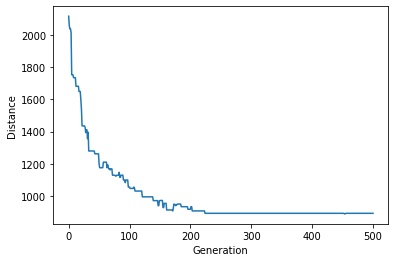

In [3]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Initial distance: 2119.6778984913353


TypeError: text must be a unicode or bytes